In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression 
import matplotlib.pylab as pylab
import math,time
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout, Activation
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

test_set_size_percentage = 20 
import pandas as pd
from pandas import read_csv
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (15, 10),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)
from sklearn.metrics import r2_score,mean_squared_error 

Using TensorFlow backend.


In [2]:
data = read_csv('dataset/train_iron.csv')
data['DATE']=pd.to_datetime(data['DATE'],format='%d/%m/%Y') 
data=data.sort_values('DATE') 
df = data
df.head()

,DATE,Price,Production
0,2008-12-01,69.982609,83.0719
1,2009-01-01,72.509091,72.3047
2,2009-02-01,75.590000,70.6748
3,2009-03-01,64.072727,52.8787
4,2009-04-01,59.781818,39.4411


In [3]:
df['Price_lag']=df['Price'].shift(1) 
df=df.set_index('DATE') 
df['rolling_mean_price']=df['Price_lag'].rolling(2, min_periods=1).sum() 
df=df.dropna() 
print('The correlation of price with other features') 
df.corr()['Price']

The correlation of price with other features


Price                 1.000000
Production            0.493812
Price_lag             0.971039
rolling_mean_price    0.953530
Name: Price, dtype: float64

In [4]:
df.head()

,Price,Production,Price_lag,rolling_mean_price
DATE,,,,
2009-01-01,72.509091,72.3047,69.982609,69.982609
2009-02-01,75.590000,70.6748,72.509091,142.491700
2009-03-01,64.072727,52.8787,75.590000,148.099091
2009-04-01,59.781818,39.4411,64.072727,139.662727
2009-05-01,62.690476,17.9050,59.781818,123.854545


In [5]:
data.head()

,DATE,Price,Production,Price_lag
0,2008-12-01,69.982609,83.0719,NaN
1,2009-01-01,72.509091,72.3047,69.982609
2,2009-02-01,75.590000,70.6748,72.509091
3,2009-03-01,64.072727,52.8787,75.590000
4,2009-04-01,59.781818,39.4411,64.072727


In [6]:
# function for min-max normalization of Iron Ore 
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
def normalize_data(df):
    df['Price'] = min_max_scaler.fit_transform(df.Price.values.reshape(-1,1))
    df['Production'] = min_max_scaler.fit_transform(df.Production.values.reshape(-1,1))
    df['Price_lag'] = min_max_scaler.fit_transform(df.Price_lag.values.reshape(-1,1))
    df['rolling_mean_price'] = min_max_scaler.fit_transform(df.rolling_mean_price.values.reshape(-1,1))
    return df

In [7]:
# normalize stock
df_stock_norm = df.copy()
df_stock_norm = normalize_data(df_stock_norm)
df_stock_norm.head()

,Price,Production,Price_lag,rolling_mean_price
DATE,,,,
2009-01-01,0.216179,0.576178,0.198910,0.000000
2009-02-01,0.237239,0.559052,0.216179,0.244280
2009-03-01,0.158514,0.372059,0.237239,0.263171
2009-04-01,0.129184,0.230864,0.158514,0.234750
2009-05-01,0.149065,0.004574,0.129184,0.181492


In [8]:
print(len(df_stock_norm))
print(len(data))

102
103


In [9]:
y=df_stock_norm['Price']
X=df_stock_norm.drop(["Price"],axis=1) 
X_train=X[:90]
y_train=y[:90]
X_train.head() 

,Production,Price_lag,rolling_mean_price
DATE,,,
2009-01-01,0.576178,0.198910,0.000000
2009-02-01,0.559052,0.216179,0.244280
2009-03-01,0.372059,0.237239,0.263171
2009-04-01,0.230864,0.158514,0.234750
2009-05-01,0.004574,0.129184,0.181492


In [10]:
y_train.head() #only the price normalize value

DATE
2009-01-01    0.216179
2009-02-01    0.237239
2009-03-01    0.158514
2009-04-01    0.129184
2009-05-01    0.149065
Name: Price, dtype: float64

In [11]:
X_train.shape

(90, 3)

In [12]:
X_train = X_train.as_matrix() #convert X_train as a matrix for RNN input

C:\Users\sumon\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [13]:
X_train.shape

(90, 3)

In [14]:
#X_train[0:5]

In [15]:
print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)

X_train.shape =  (90, 3)
y_train.shape =  (90,)


In [16]:
#Reshape data for (Sample,Timestep,Features) 
x_train = X_train.reshape((X_train.shape[0],1,X_train.shape[1]))
x_train.shape

(90, 1, 3)

In [17]:
#Build the model
model = Sequential()
model.add(LSTM(256,input_shape=(1,3))) # (sample,timestep,feature)
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse', metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               266240    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 282,753
Trainable params: 282,753
Non-trainable params: 0
_________________________________________________________________


In [19]:
#Fit model with history to check for overfitting
history = model.fit(x_train,y_train,epochs=20,shuffle=False)


Epoch 1/20
90/90 [==============================] - 0s 4ms/step - loss: 0.2888 - accuracy: 0.0111
Epoch 2/20
90/90 [==============================] - 0s 310us/step - loss: 0.2392 - accuracy: 0.0111
Epoch 3/20
90/90 [==============================] - 0s 288us/step - loss: 0.1968 - accuracy: 0.0111
Epoch 4/20
90/90 [==============================] - 0s 355us/step - loss: 0.1552 - accuracy: 0.0111
Epoch 5/20
90/90 [==============================] - 0s 277us/step - loss: 0.1146 - accuracy: 0.0111
Epoch 6/20
90/90 [==============================] - 0s 299us/step - loss: 0.0794 - accuracy: 0.0111
Epoch 7/20
90/90 [==============================] - 0s 355us/step - loss: 0.0529 - accuracy: 0.0222
Epoch 8/20
90/90 [==============================] - 0s 310us/step - loss: 0.0374 - accuracy: 0.0222
Epoch 9/20
90/90 [==============================] - 0s 244us/step - loss: 0.0321 - accuracy: 0.0222
Epoch 10/20
90/90 [==============================] - 0s 299us/step - loss: 0.0324 - accuracy: 0.0222


In [20]:
test_data=data[90:] 
test_data=test_data.set_index('DATE')
actual_price=pd.DataFrame()
actual_price = min_max_scaler.fit_transform(test_data['Price'].values.reshape(-1,1))
#actual_price=test_data['Price']
test_data=test_data.drop(["Price"],axis=1)
test_data #for prediction

,Production,Price_lag
DATE,,
2016-06-01,84.4591,55.886364
2016-07-01,82.6145,52.340909
2016-08-01,75.9245,57.309524
2016-09-01,74.5910,60.869565
2016-10-01,78.7257,57.659091
2016-11-01,74.1908,58.952381
2016-12-01,77.3206,74.136364
2017-01-01,79.2234,79.431818
2017-02-01,82.7242,80.818182


In [21]:
actual_price #price for predction

array([[0.        ],
       [0.13627917],
       [0.23392399],
       [0.1458671 ],
       [0.18133946],
       [0.59780576],
       [0.7430495 ],
       [0.78107468],
       [1.        ],
       [0.95599595],
       [0.49532477],
       [0.25479312],
       [0.15147737]])

In [22]:
X[88:90]

,Production,Price_lag,rolling_mean_price
DATE,,,
2016-05-01,0.721929,0.137282,0.160104
2016-06-01,0.703890,0.102557,0.157905


In [23]:
x = X[88:89].as_matrix()
test_forecast = np.reshape(x,(1,1,3))
t = model.predict(test_forecast)
val = X[88:89][['Production','Price_lag']]
n = val.values.tolist()[0]

C:\Users\sumon\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [24]:
test_data['Production'] = min_max_scaler.fit_transform(test_data.Production.values.reshape(-1,1))
test_data['Price_lag'] = min_max_scaler.fit_transform(test_data.Price_lag.values.reshape(-1,1))
#df['rolling_mean_price'] = min_max_scaler.fit_transform(df.rolling_mean_price.values.reshape(-1,1))
test_data

,Production,Price_lag
DATE,,
2016-06-01,0.476229,0.097245
2016-07-01,0.390679,0.000000
2016-08-01,0.080406,0.136279
2016-09-01,0.018561,0.233924
2016-10-01,0.210322,0.145867
2016-11-01,0.000000,0.181339
2016-12-01,0.145156,0.597806
2017-01-01,0.233405,0.743049
2017-02-01,0.395767,0.781075


In [26]:
prediction=[]
for i in range(1,len(test_data)+1):
    forecastdata=test_data[i-1:i]['Production'] 
    print(forecastdata)
    o=forecastdata.values 
    y=list(np.append(o,t))
    forecast=pd.DataFrame(columns=['Production','Price_lag']) 
    print("y = ",y)
    print("n = ",n)

    forecast.loc[0]=n 
    forecast.loc[1]=y
    forecast['rolling_mean_price']=forecast['Price_lag'].rolling(2,min_periods=1).sum()
    x = forecast[-1:].as_matrix()
    new_val = np.reshape(x,(1,1,3))
    t=model.predict(new_val) 
    n=y 
    print(forecast) 
    print('the predicted price',t)
    print('the actual price',actual_price[i-1])
    prediction.append(t)

DATE
2016-06-01    0.476229
Name: Production, dtype: float64
y =  [0.4762286832670899, 0.2782604694366455]
n =  [0.7219290051623248, 0.13728240668909308]
   Production  Price_lag  rolling_mean_price
0    0.721929   0.137282            0.137282
1    0.476229   0.278260            0.415543
the predicted price [[0.36085212]]
the actual price [0.]
DATE
2016-07-01    0.390679
Name: Production, dtype: float64
y =  [0.3906788425773482, 0.36085212230682373]
n =  [0.4762286832670899, 0.2782604694366455]
   Production  Price_lag  rolling_mean_price
0    0.476229   0.278260            0.278260
1    0.390679   0.360852            0.639113
the predicted price [[0.43672177]]
the actual price [0.13627917]
DATE
2016-08-01    0.080406
Name: Production, dtype: float64
y =  [0.08040646145712049, 0.4367217719554901]
n =  [0.3906788425773482, 0.36085212230682373]
   Production  Price_lag  rolling_mean_price
0    0.390679   0.360852            0.360852
1    0.080406   0.436722            0.797574
the predic

C:\Users\sumon\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [27]:
pred = []
for i in range(len(prediction)):
    print(prediction[i][0][0])
    pred.append(prediction[i][0][0])

0.36085212
0.43672177
0.46480763
0.4937437
0.5431938
0.552969
0.5912043
0.6283593
0.68281925
0.7249347
0.84908426
0.8682705
0.9160311


In [28]:
act_price = []
for i in range(len(actual_price)):
    print(actual_price[i][0])
    act_price.append(prediction[i][0][0])

0.0
0.13627917197017148
0.23392399308729783
0.14586709891171035
0.18133946006280177
0.597805759990081
0.743049495031965
0.7810746790230378
1.0000000000000002
0.9559959453196363
0.4953247724848444
0.25479312451677383
0.15147737182018517


Text(0.5, 1.0, 'Predicted value')

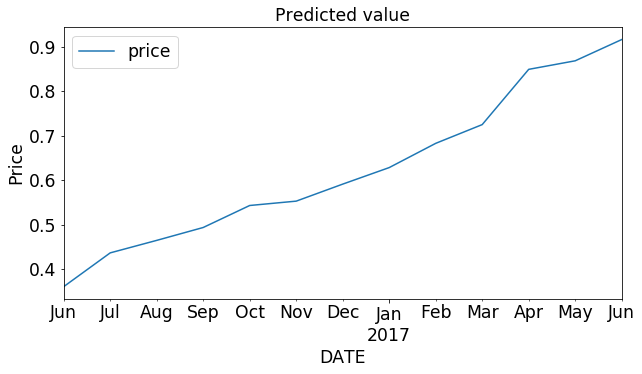

In [29]:
predictdata=pd.DataFrame(pred,index=test_data.index,columns=['price'])
predictdata.plot(figsize=(10,5))
plt.ylabel("Price")
plt.title("Predicted value")

Text(0.5, 1.0, 'Actual value')

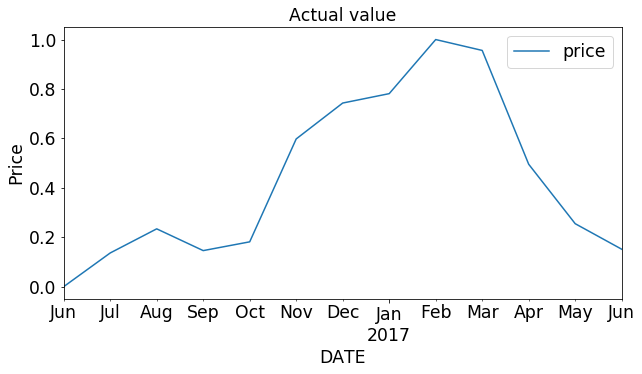

In [30]:
actual_price=pd.DataFrame(actual_price,index=test_data.index,columns=['price'])
actual_price.plot(figsize=(10,5))
plt.ylabel("Price")
plt.title("Actual value")

Text(0, 0.5, 'Price')

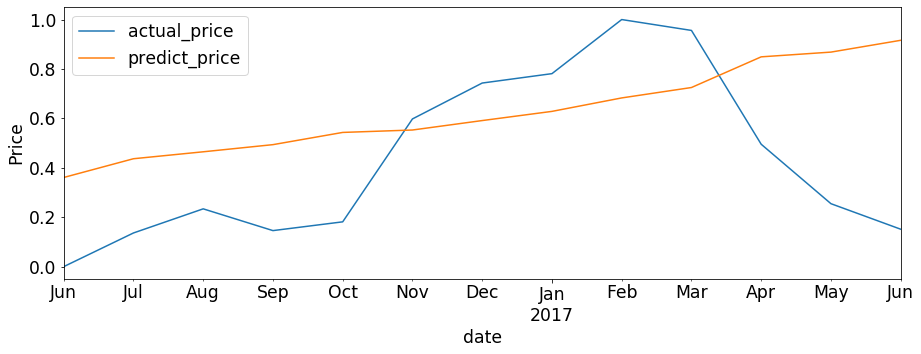

In [31]:
# In normalize condition
new_df = pd.DataFrame(columns=['date','actual_price','predict_price'])
new_df['date'] = actual_price.index
new_df['actual_price'] = actual_price['price'].values
new_df['predict_price'] = predictdata['price'].values
new_df = new_df.set_index('date')
new_df.plot(figsize=(15,5))
plt.ylabel("Price")

In [32]:
def denormalize(df, normalized_value): 
    df = df['Price'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    #return df.shape, p.shape
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

newp = denormalize(data[90:], np.array(predictdata))
#newy_test = denormalize(data[90:], np.array(actual_price))

In [34]:
import pandas as pd
act_pred = pd.concat([pd.DataFrame(newp), pd.DataFrame(data[90:]['Price'].values)], axis=1)
act_pred.columns = ['Predicted', 'Actual']

In [35]:
act_pred['date'] = predictdata.index

In [36]:
act_pred=act_pred.set_index('date')

Text(0, 0.5, 'Price')

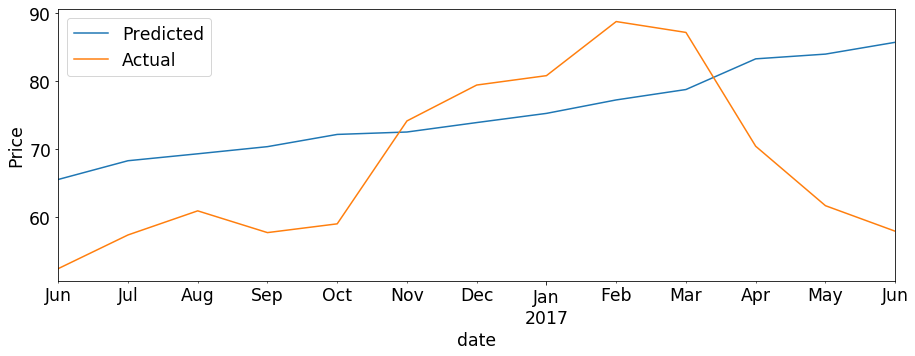

In [37]:
# In denormalize condition
act_pred.plot(figsize=(15, 5))
plt.ylabel("Price")

In [38]:
print("RSME")
print(mean_squared_error(actual_price,pred))

RSME
0.1395514537084866
